# Mutual Information Example

This notebook demonstrates how to compute mutual information between species states at different time points using `stochastix.analysis.mutual_information` and `stochastix.analysis.state_mutual_info`.

We'll use a simple one-gene model with:
1. **Production**: 0 → Gene (rate constant k_prod)
2. **Degradation**: Gene → 0 (rate constant k_degr)

We'll compute the mutual information between the gene state at different time points to quantify temporal correlations in the stochastic dynamics.


In [1]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt
import numpy as np

import stochastix as stx
from stochastix import Reaction, ReactionNetwork
from stochastix.kinetics import MassAction
from stochastix.analysis import mutual_information, state_mutual_info

# import jax
# jax.config.update('jax_enable_x64', True)
key = rng.PRNGKey(3)

plt.rcParams['font.size'] = 14

/Users/francesco/Documents/GitHub/stochastix/stochastix/utils/__init__.py:3: FutureWarning: The 'stochastix.utils.optimization' module is experimental and it may change or be removed without notice in future versions.
  from . import nn, optimization, visualization


## 1. Define the Model

We create a simple gene regulation model with production and degradation reactions.


In [2]:
# Rate constants
k_prod = 0.1  # production rate (1/s)
k_degr = 0.05  # degradation rate (1/s)

# Create reaction network
network = ReactionNetwork(
    [
        Reaction('0 -> Gene', MassAction(k=k_prod), name='production'),
        Reaction('Gene -> 0', MassAction(k=k_degr), name='degradation'),
    ]
)

print(f'Production rate: {k_prod:.3f} (1/s)')
print(f'Degradation rate: {k_degr:.3f} (1/s)')
print(f'Steady-state mean: {k_prod / k_degr:.1f} molecules')

Production rate: 0.100 (1/s)
Degradation rate: 0.050 (1/s)
Steady-state mean: 2.0 molecules


## 2. Run Batched Simulations

We run multiple simulations starting from the same initial condition to generate a distribution of trajectories. This allows us to compute mutual information between states at different time points.


In [3]:
# Simulation parameters
T = 100.0  # total simulation time (seconds)
n_simulations = 1000  # number of parallel simulations
x0 = jnp.array([0.0])  # initial state: 0 molecules

# Generate random keys for each simulation
keys = rng.split(key, n_simulations)


# Run batched simulations using Equinox filtered vmap
def run_single_sim(key):
    return stx.stochsimsolve(
        key, network, x0, T=T, solver=stx.DifferentiableDirect(), max_steps=int(1e4)
    )


vmapped_sim = eqx.filter_vmap(run_single_sim, in_axes=(0,))
results = vmapped_sim(keys)
print(f'Ran {n_simulations} simulations')
print(f'Simulation time points: {len(results.t[0])} steps')

Ran 1000 simulations
Simulation time points: 10001 steps


## 3. Visualize Sample Trajectories

Let's first look at a few sample trajectories to understand the dynamics.


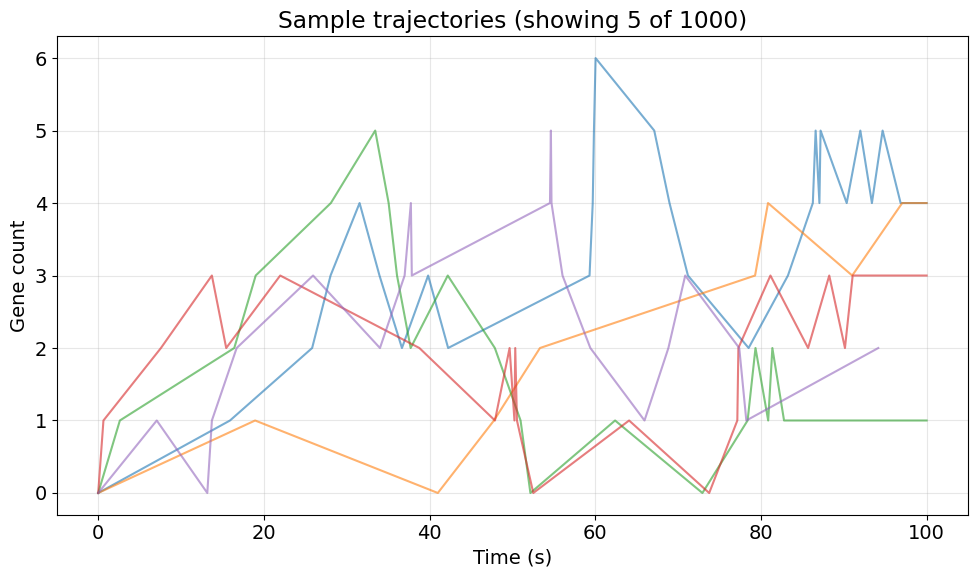

In [4]:
# Plot a few sample trajectories
fig, ax = plt.subplots(figsize=(10, 6))

n_samples = 5
for i in range(n_samples):
    traj = results.x[i]
    times = results.t[i]
    # Remove padded zeros
    valid = times <= T
    ax.plot(times[valid], traj[valid, 0], alpha=0.6, linewidth=1.5)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Gene count')
ax.set_title(f'Sample trajectories (showing {n_samples} of {n_simulations})')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Manually Compute Mutual Information Between Time Points

We'll compute the mutual information between the gene state at different time points. Mutual information quantifies how much information about the state at one time point is contained in the state at another time point.

We'll compute MI between:
- Gene state at t=0 and Gene state at various later time points


In [5]:
# Extract gene counts at different time points

# Get gene counts at t=0 (initial state)
gene_at_t0 = results.interpolate(jnp.array([10.0])).x[:, 0]

# Compute MI between t=0 and various later time points
time_points = jnp.linspace(10, 90, 9)  # time points to evaluate
mi_values = []

for t in time_points:
    # Extract gene counts at time t using interpolation (wrap scalar in array)
    gene_at_t = results.interpolate(jnp.array([t])).x[:, 0]

    # Compute mutual information
    mi = mutual_information(
        gene_at_t0,
        gene_at_t,
        n_grid_points1=None,
        n_grid_points2=None,
        bw_multiplier=1.0,
    )

    print(f'MI between Gene(t=10) and Gene(t={t}): {mi:.4f} bits')
    mi_values.append(float(mi))

mi_values = jnp.array(mi_values)

MI between Gene(t=10) and Gene(t=10.0): 1.6665 bits
MI between Gene(t=10) and Gene(t=20.0): 0.1923 bits
MI between Gene(t=10) and Gene(t=30.0): 0.0624 bits
MI between Gene(t=10) and Gene(t=40.0): 0.0427 bits
MI between Gene(t=10) and Gene(t=50.0): 0.0254 bits
MI between Gene(t=10) and Gene(t=60.0): 0.0195 bits
MI between Gene(t=10) and Gene(t=70.0): 0.0295 bits
MI between Gene(t=10) and Gene(t=80.0): 0.0228 bits
MI between Gene(t=10) and Gene(t=90.0): 0.0224 bits


### 5. With `state_mutual_info` Convenience Function

Alternatively, we can use the `state_mutual_info` function which is more convenient when working with `SimulationResults` objects.


In [6]:
# Using state_mutual_info - compute MI between Gene at t=0 and Gene at t=50
mi_convenient = state_mutual_info(
    results,
    species_at_t=[('Gene', 10.0), ('Gene', 50.0)],
    n_grid_points1=None,
    n_grid_points2=None,
    bw_multiplier=1.0,
)

print(f'Mutual information between Gene(t=10) and Gene(t=50): {mi_convenient:.4f} bits')

Mutual information between Gene(t=10) and Gene(t=50): 0.0254 bits


Mean at t=0: 0.81
Mean at t=50: 1.78


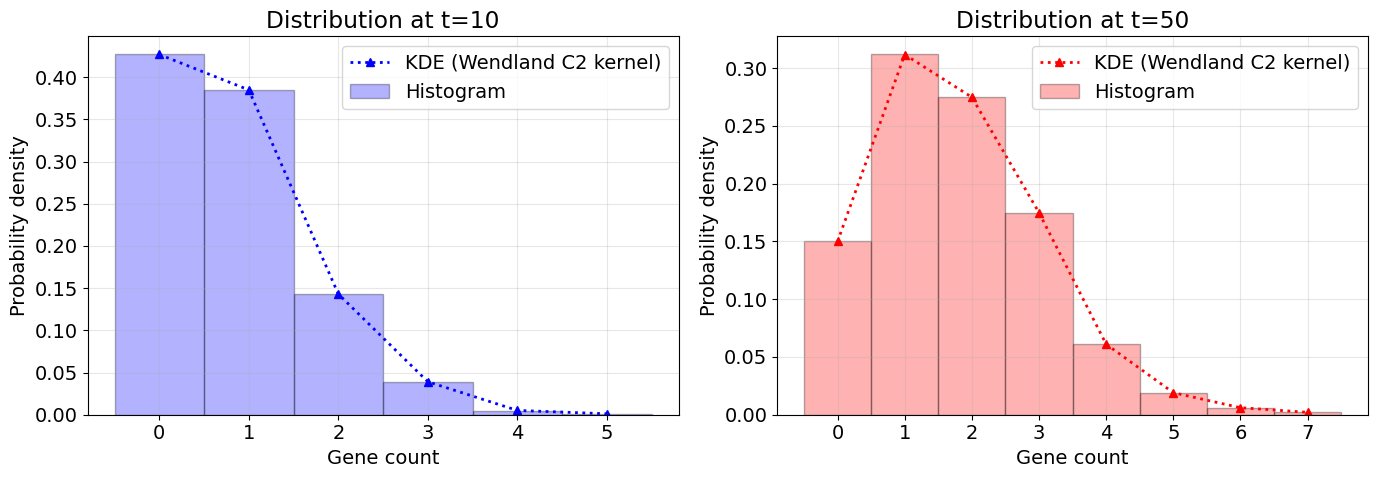

In [7]:
from stochastix.analysis import kde_wendland_c2

# Extract gene counts at two time points for comparison
gene_at_t0 = results.interpolate(jnp.array([10.0])).x[:, 0]
gene_at_t50 = results.interpolate(jnp.array([50.0])).x[:, 0]

print(f'Mean at t=0: {jnp.mean(gene_at_t0):.2f}')
print(f'Mean at t=50: {jnp.mean(gene_at_t50):.2f}')

# Compute KDE for both distributions using Wendland C2 kernels
grid1, p_x1 = kde_wendland_c2(
    gene_at_t0,
    n_grid_points=None,
    density=True,
    bw_multiplier=1.0,
)

grid2, p_x2 = kde_wendland_c2(
    gene_at_t50,
    n_grid_points=None,
    density=True,
    bw_multiplier=1.0,
)

# Plot both distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution at t=0
ax1.plot(grid1, p_x1, '^b:', linewidth=2, label='KDE (Wendland C2 kernel)')
# Use bincount for discrete histogram at t=0
gene_t0_flat = np.asarray(gene_at_t0).flatten().astype(int)
max_bin_t0 = gene_t0_flat.max()
bin_counts_t0 = np.bincount(gene_t0_flat, minlength=max_bin_t0 + 1)
bin_edges_t0 = np.arange(max_bin_t0 + 2) - 0.5  # Center bins on integers

# Convert to density, matching matplotlib's density=True
total_t0 = bin_counts_t0.sum()
bin_width_t0 = 1
hist_density_t0 = (
    bin_counts_t0 / (total_t0 * bin_width_t0) if total_t0 > 0 else bin_counts_t0
)

ax1.bar(
    np.arange(max_bin_t0 + 1),
    hist_density_t0,
    width=1,
    alpha=0.3,
    color='blue',
    label='Histogram',
    align='center',
    edgecolor='k',
)
ax1.set_xlabel('Gene count')
ax1.set_ylabel('Probability density')
ax1.set_title('Distribution at t=10')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution at t=50
ax2.plot(grid2, p_x2, '^r:', linewidth=2, label='KDE (Wendland C2 kernel)')
# Use bincount for discrete histogram
gene_t50_flat = np.asarray(gene_at_t50).flatten().astype(int)
max_bin = gene_t50_flat.max()
bin_counts = np.bincount(gene_t50_flat, minlength=max_bin + 1)
bin_edges = np.arange(max_bin + 2) - 0.5  # Center bins on integers

# Convert to density if requested, following matplotlib's `density=True` style
total = bin_counts.sum()
bin_width = 1  # For integer gene counts, bin width is 1
hist_density = bin_counts / (total * bin_width) if total > 0 else bin_counts

ax2.bar(
    np.arange(max_bin + 1),
    hist_density,
    width=1,
    alpha=0.3,
    color='red',
    label='Histogram',
    align='center',
    edgecolor='k',
)
ax2.set_xlabel('Gene count')
ax2.set_ylabel('Probability density')
ax2.set_title('Distribution at t=50')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualize Mutual Information Over Time

Plot how mutual information decays as the time separation increases.


MI at t=10s: 1.6665 bits
MI at t=90s: 0.0224 bits


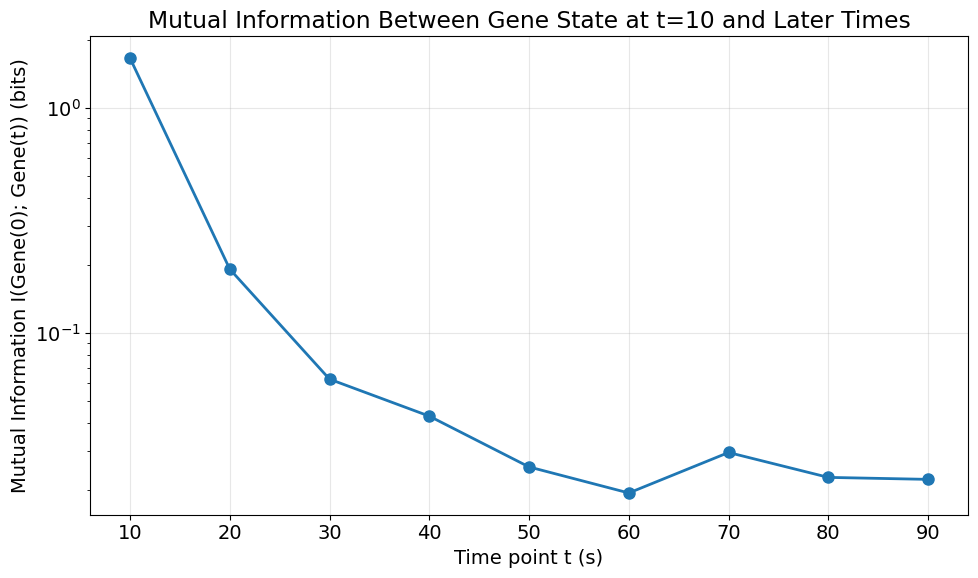

In [8]:
print(f'MI at t=10s: {mi_values[0]:.4f} bits')
print(f'MI at t=90s: {mi_values[-1]:.4f} bits')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time_points, mi_values, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Time point t (s)')
ax.set_ylabel('Mutual Information I(Gene(0); Gene(t)) (bits)')
ax.set_title('Mutual Information Between Gene State at t=10 and Later Times')
ax.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

## 7. Joint Distribution Visualization

Let's visualize the joint distribution between Gene(t=0) and Gene(t=50) to better understand the relationship.


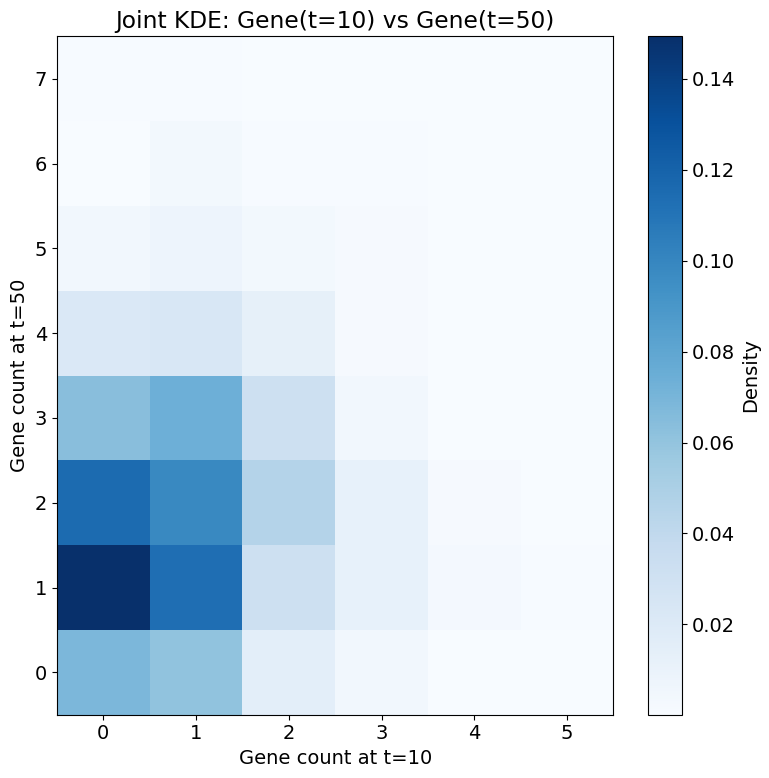

In [9]:
# Extract data at t=10 and t=50
gene_t0 = results.interpolate(jnp.array([10.0])).x[:, 0]
gene_t50 = results.interpolate(jnp.array([50.0])).x[:, 0]

# Convert JAX arrays to numpy arrays for plotting
gene_t0_np = np.asarray(gene_t0).flatten()
gene_t50_np = np.asarray(gene_t50).flatten()

# Use stx.kde_wendland_c2_2d for KDE-based joint density plot
grid1, grid2, p_x1_x2 = stx.analysis.kde_wendland_c2_2d(gene_t0_np, gene_t50_np)

# Create 2D meshgrids for pcolormesh
X, Y = np.meshgrid(grid1, grid2, indexing='ij')
Z = np.asarray(p_x1_x2)

fig, ax = plt.subplots(figsize=(8, 8))
c = ax.pcolormesh(X, Y, Z, cmap='Blues', shading='auto')
ax.set_xlabel('Gene count at t=10')
ax.set_ylabel('Gene count at t=50')
ax.set_title('Joint KDE: Gene(t=10) vs Gene(t=50)')
plt.colorbar(c, ax=ax, label='Density')
plt.tight_layout()
plt.show()